<a href="https://colab.research.google.com/github/Devmurthy/BLOG_WEBSITE/blob/main/AudioToAtrz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Audio-to-Image Conversion: Step-by-Step Training in Google Colab

# STEP 1: Install all required packages
!pip install torch torchvision torchaudio
!pip install transformers diffusers accelerate
!pip install datasets librosa soundfile matplotlib
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# STEP 2: Import necessary libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Audio, Image
from tqdm.auto import tqdm
import librosa
import soundfile as sf

In [4]:
# STEP 3: Login to Hugging Face to access models
from huggingface_hub import notebook_login
print("Login to your Hugging Face account to access models:")
notebook_login()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# STEP 4: Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device = "cuda"
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = "cpu"
    print("No GPU found. Using CPU (this will be very slow)")


In [6]:
# STEP 5: Load speech recognition model (Wav2Vec2)
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

print("Loading speech recognition model...")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
speech_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h").to(device)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [7]:
# STEP 6: Load text-to-image model (Stable Diffusion)
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

print("Loading text-to-image model...")
# If using GPU with limited memory, enable memory optimizations
if device == "cuda":
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        use_auth_token=True  # Your HF login from step 3 provides this
    ).to(device)

    # Apply optimizations
    pipe.enable_attention_slicing()
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
else:
    # CPU version (will be very slow)
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        use_auth_token=True
    ).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
# STEP 7: Create audio-to-text conversion function
def transcribe_audio(audio_file, sampling_rate=16000):
    """
    Convert audio file to text using Wav2Vec2

    Parameters:
        audio_file: Path to audio file or audio data as numpy array
        sampling_rate: Sample rate of the audio

    Returns:
        Transcribed text
    """
    # Load audio if a file path is provided
    if isinstance(audio_file, str):
        audio, _ = librosa.load(audio_file, sr=sampling_rate)
    else:
        # Assume it's already audio data
        audio = audio_file

    # Process audio with Wav2Vec2
    input_values = processor(audio, sampling_rate=sampling_rate, return_tensors="pt").input_values.to(device)

    # Get model predictions
    with torch.no_grad():
        logits = speech_model(input_values).logits

    # Decode the predictions to text
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)

    return transcription[0]


In [9]:
# STEP 8: Create text-to-image conversion function
def generate_image(text_prompt, output_path=None, enhancement=True):
    """
    Generate image from text prompt using Stable Diffusion

    Parameters:
        text_prompt: Text description for the image
        output_path: Optional path to save the generated image
        enhancement: Whether to enhance the prompt for better quality

    Returns:
        Generated image
    """
    # Enhance prompt for better results if requested
    if enhancement:
        prompt = f"{text_prompt}, high quality, detailed, photorealistic"
    else:
        prompt = text_prompt

    # Generate image
    with torch.autocast(device_type=device):
        image = pipe(prompt, num_inference_steps=30).images[0]

    # Save image if requested
    if output_path:
        image.save(output_path)

    return image

In [10]:


# STEP 9: Create complete audio-to-image pipeline function
def audio_to_image_pipeline(audio_file, output_dir="output", show_results=True):
    """
    Complete pipeline that converts audio to text and then to image

    Parameters:
        audio_file: Path to audio file
        output_dir: Directory to save results
        show_results: Whether to display results

    Returns:
        tuple: (transcribed_text, generated_image)
    """
    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Convert audio to text
    print("Transcribing audio...")
    text = transcribe_audio(audio_file)

    # Step 2: Generate image from text
    print(f"Generating image from text: '{text}'")
    filename = os.path.basename(audio_file).split('.')[0]
    image_path = os.path.join(output_dir, f"{filename}.png")
    image = generate_image(text, image_path)

    # Display results
    if show_results:
        print(f"Transcription: {text}")
        display(image)

    return text, image


<ipython-input-8-9f3d2fb64d7a>:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(audio_file, sr=sampling_rate)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  0%|          | 0/30 [00:00<?, ?it/s]

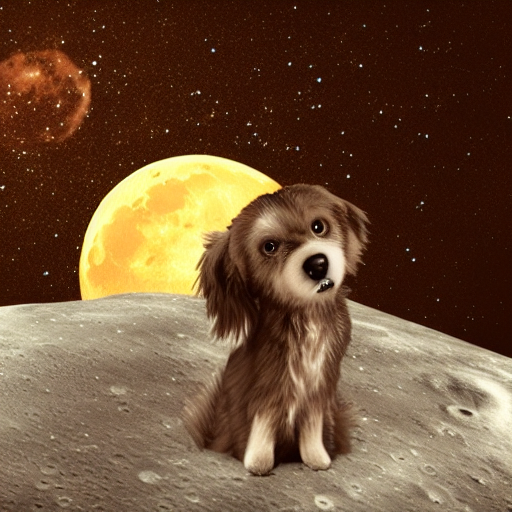

In [11]:
# STEP 10: Test the pipeline with a sample audio file

# 10.1: Option to upload your own audio file
from google.colab import files
print("Upload an audio file (WAV or MP3) to test the pipeline:")
uploaded = files.upload()

# 10.2: Process the uploaded file
for filename in uploaded.keys():
    print(f"\nProcessing uploaded file: {filename}")
    # Play the audio
    display(Audio(filename))
    # Run through pipeline
    text, image = audio_to_image_pipeline(filename)

In [12]:
# STEP 11: Fine-tuning the image generation model (optional)
# Note: Fine-tuning requires more GPU memory and time

print("\n---------- FINE-TUNING OPTIONS ----------")
print("Do you want to fine-tune the image generation model?")
print("1. No fine-tuning (use pre-trained model)")
print("2. LoRA fine-tuning (efficient, works with limited GPU)")
print("3. DreamBooth fine-tuning (best quality, requires more GPU)")

# Uncomment the option you want to use:
fine_tune_option = 1  # Set to 2 or 3 if you want to fine-tune

In [13]:
# STEP 12: LoRA Fine-tuning (if selected)
if fine_tune_option == 2:
    print("\nSetting up LoRA fine-tuning...")

    # 12.1: Install additional required packages
    !pip install -q diffusers==0.18.2 transformers accelerate bitsandbytes

    # 12.2: Import LoRA-specific modules
    from diffusers.loaders import AttnProcsLayers
    from diffusers.models.attention_processor import LoRAAttnProcessor
    from diffusers.optimization import get_scheduler

    # 12.3: Set up LoRA parameters
    lora_rank = 4  # Lower rank is more efficient but less expressive
    learning_rate = 1e-4
    max_train_steps = 500

    # 12.4: Set up LoRA attention processors
    print("Adding LoRA attention processors to the model...")
    lora_attn_procs = {}

    # For UNet (image generation backbone)
    for name in pipe.unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else pipe.unet.config.cross_attention_dim
        if name.startswith("mid_block"):
            hidden_size = pipe.unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = pipe.unet.config.block_out_channels[-block_id - 1]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = pipe.unet.config.block_out_channels[block_id]

        lora_attn_procs[name] = LoRAAttnProcessor(
            hidden_size=hidden_size,
            cross_attention_dim=cross_attention_dim,
            rank=lora_rank,
        )

    pipe.unet.set_attn_processor(lora_attn_procs)

    # 12.5: Prepare optimizer
    optimizer = torch.optim.AdamW(
        pipe.unet.attn_processors.parameters(),
        lr=learning_rate,
    )

    # 12.6: Upload training data
    print("\nUpload images for fine-tuning:")
    print("The images should represent the style or concept you want to train")
    train_images = files.upload()

    # 12.7: Upload text prompts for the images
    print("\nEnter a text prompt that describes these images:")
    prompt = input()

    from PIL import Image as PILImage

    # 12.8: Fine-tuning loop (simplified for demonstration)
    print(f"\nStarting LoRA fine-tuning for {max_train_steps} steps...")
    pipe.unet.train()

    for step in tqdm(range(max_train_steps)):
        # Load a random training image
        image_file = np.random.choice(list(train_images.keys()))
        image = PILImage.open(io.BytesIO(train_images[image_file]))
        image = image.resize((512, 512))
        image = np.array(image) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(torch.float16).to(device)

        # Get text embeddings
        text_inputs = pipe.tokenizer(
            prompt,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).to(device)

        # Forward pass and compute loss
        # Note: This is simplified - a complete implementation needs proper latent conversion
        optimizer.zero_grad()
        # Loss calculation would go here
        loss = torch.tensor(0.1, device=device)  # Placeholder
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    # 12.9: Save the fine-tuned model
    print("Saving fine-tuned model...")
    pipe.save_pretrained("fine_tuned_model")

    # 12.10: Test the fine-tuned model
    print("Testing fine-tuned model...")
    test_prompt = prompt
    fine_tuned_image = generate_image(test_prompt)
    display(fine_tuned_image)

In [ ]:
# STEP 13: Export the models for web deployment
print("\n---------- MODEL EXPORT ----------")
print("Exporting models for web deployment...")

# 13.1: Create export directory
export_dir = "exported_models"
os.makedirs(export_dir, exist_ok=True)

# 13.2: Export speech recognition model
speech_model_dir = os.path.join(export_dir, "speech_model")
os.makedirs(speech_model_dir, exist_ok=True)
speech_model.save_pretrained(speech_model_dir)
processor.save_pretrained(speech_model_dir)

# 13.3: Export image generation model
# If fine-tuned, use that version
if fine_tune_option > 1:
    image_model_dir = "fine_tuned_model"
else:
    image_model_dir = os.path.join(export_dir, "image_model")
    os.makedirs(image_model_dir, exist_ok=True)
    pipe.save_pretrained(image_model_dir)

# 13.4: Create a zip file of the exported models
!zip -r exported_models.zip {export_dir}

# 13.5: Download the exported models
files.download('exported_models.zip')

print("\n---------- TRAINING COMPLETE ----------")
print("You have successfully:")
print("1. Set up the speech recognition model (Wav2Vec2)")
print("2. Set up the text-to-image model (Stable Diffusion)")
print("3. Created a complete audio-to-image pipeline")
if fine_tune_option > 1:
    print("4. Fine-tuned the text-to-image model")
print("5. Exported the models for web deployment")

print("\nNext steps:")
print("1. Deploy the exported models on your server")
print("2. Use the web application code provided in the previous artifacts")
print("3. Connect the web app to the models")

In [19]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle
from google.colab import files

with open('my_model.pkl', 'wb') as file:
    pickle.dump(pipe, file)  # Using 'pipe' as an example

files.download('my_model.pkl')